# Show spatial clustering capabilities of PyPSA-Earth

The below plots demonstrate the clustering capabilities of PyPSA. **High spatial resolution is important to avoid information loss that make renewable investment expansion expensive**. For instance, in a high aggregated case, e.g. 1 node per country, the countries average wind potential can be used to optimise onshore wind power plants that can generate 2500 per year. If one would use the same wind potential in Nigeria but increase the spatial resolution, let's say to 50 nodes, one can observe that now high wind location are available which leads to the case that the same wind power plant can generate suddenly 5000h per year which saves costs. In an EU study, it was observed that using high resolved renewable can reduce the total system costs by 10\% [1] underlining the importance. Let's use then high resolution!

However, using high resolution can be computationally expensive. Setting in the `config.yaml` the `clusters` option does make the optimization problem quite big especially because the network constraints are quite heavy.
```python
clusters: [4, 14, 54]
```
Using the `simpl` option allows you to have high spatial resolution for renewables but reduce the network resolution making the optimization problem lean. 
```python
simpl: [54]
```

The below figures are created with the following config options:

```python
scenario:
  simpl: [54]
  ll: ['copt']
  clusters: [4, 14, 54]
  opts: [Co2L-12H]

countries: ["NG"]

snapshots:
  start: "2013-01-01"
  end: "2013-01-02"
  inclusive: "left" # end is not inclusive
```

Reference: 
[1] Frystacki et al. (2021). The strong effect of network resolution on electricity system models with high shares of wind and solar. Applied Energy. https://www.sciencedirect.com/science/article/pii/S0306261921002439

#### Change current directory

In [3]:
# change current directory
import os
import sys

# module_path = os.path.abspath(os.path.join('../../')) # To import helpers
# if module_path not in sys.path:
#     sys.path.append(module_path+"/pypsa-earth/scripts")
    
# from _helpers import sets_path_to_root

# sets_path_to_root("pypsa-earth-project")

#### Load imports

In [4]:
import pypsa
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#### Perform calculations

In [5]:
# customize your plot
resolutions = [4, 5, 10]  # must be 3 numbers, try to make three runs with different clusters
plot_capfacs = (
    "onwind"  # colors in the back represent capacity factors for this technology
)
cmap = "Wistia"  # colormap for upper technology
red_linewidth = 3
red_bussizes = 5e-2

INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\xenia\\Desktop\\Thesis_Code\\Code\\pypsa-earth_working\\pypsa-earth\\networks\\elec_s_5.nc'

c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


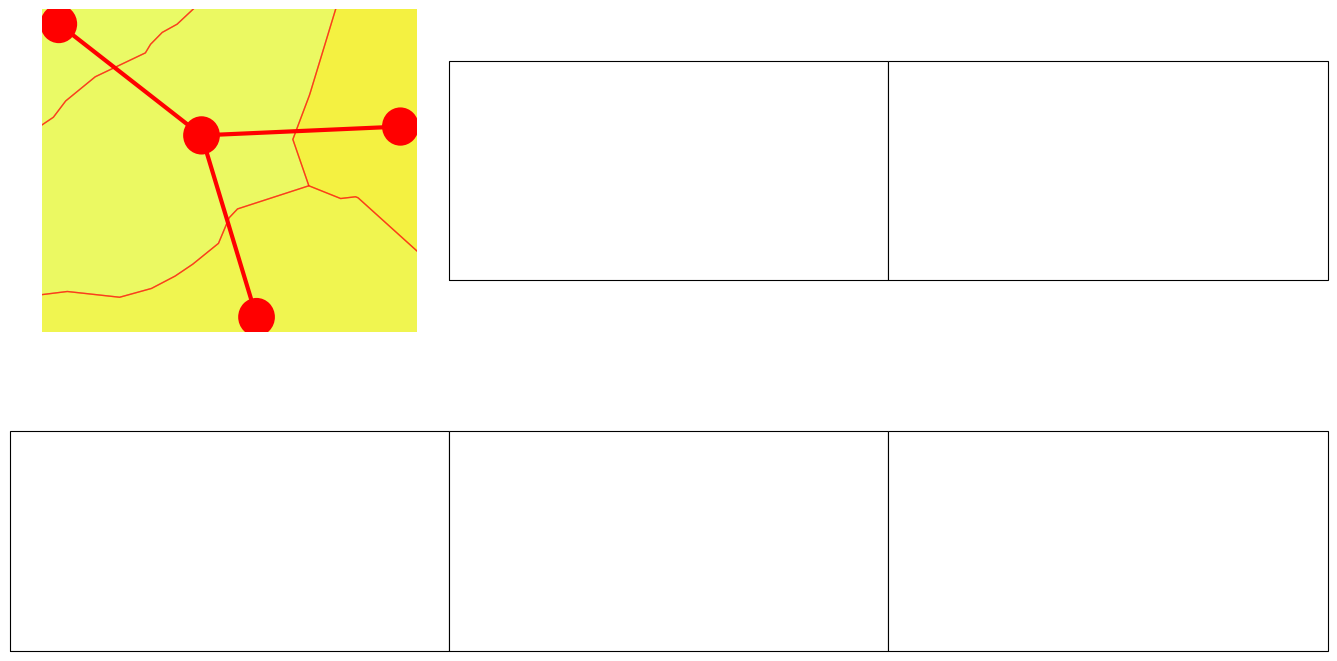

In [6]:
home = 'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/'

fig, axes = plt.subplots(
    2, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(17, 9)
)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.15)

country = gpd.read_file(home + "resources/shapes/country_shapes.geojson")

c = 0
for ax in axes[0, :]:
    n = pypsa.Network(home + f"networks/elec_s_{resolutions[c]}.nc")
    r = gpd.read_file(home + 
        f"resources/bus_regions/regions_onshore_elec_s_{resolutions[c]}.geojson"
    ).set_index("name")
    factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
    factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
    r["factor"] = factor

    n.plot(
        color_geomap=True,
        bus_colors="red",
        bus_sizes=red_bussizes,
        line_colors="red",
        line_widths=red_linewidth,
        ax=ax,
    )
    r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
    r.plot(ax=ax, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
    country.boundary.plot(ax=ax, color="black", alpha=0.75)
    c += 1

c = 0
n = pypsa.Network(home + "networks/elec_s_10.nc")
r = gpd.read_file(home + "resources/bus_regions/regions_onshore_elec_s_10.geojson").set_index("name")
b = pd.read_csv(home + "resources/bus_regions/busmap_elec_s_10.csv", index_col=0).squeeze("columns")

for ax in axes[1, :]:
    n2 = pypsa.Network(home + f"networks/elec_s_{resolutions[c]}.nc")
    r2 = gpd.read_file(
        home + f"resources/bus_regions/regions_onshore_elec_s_{resolutions[c]}.geojson"
    ).set_index("name")
    factor = n2.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
    factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
    r2["factor"] = factor

    b2 = pd.read_csv(
        home + f"resources/bus_regions/busmap_elec_s_{resolutions[c]}.csv", index_col=0
    ).squeeze("columns")
    n2.mremove("Line", n2.lines.index)

    debug = 0
    for nb in b.unique():
        nl = b2.loc[b[b == nb].index].unique()
        nb = n.buses.loc[nb]
        nb.name = nb.name + " ref"
        n2.madd("Bus", names=[nb.name], x=nb.x, y=nb.y)
        n2.madd(
            "Line", names=nl + f" ref line {debug}", bus0=[nb.name] * len(nl), bus1=nl
        )

        debug += 1

    n.plot(
        color_geomap=True,
        bus_colors="red",
        bus_sizes=red_bussizes,
        line_colors="red",
        line_widths=red_linewidth,
        ax=ax,
    )
    n2.plot(bus_colors="grey", bus_sizes=1e-2, line_colors="grey", ax=ax)
    r2.boundary.plot(ax=ax, color="grey", linewidth=0.25, alpha=0.5)
    r2.plot(ax=ax, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
    r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
    country.boundary.plot(ax=ax, color="black", alpha=0.75)

    c += 1

axes[0, 1].set_title(
    "Clustering all information simultaneously", fontsize=15
)  # , FontWeight = 'bold')
axes[1, 1].set_title(
    "Possibility to increase intra-nodal siting information", fontsize=15
)  # , FontWeight = 'bold')

# Draw a horizontal line
line = plt.Line2D([0.14, 0.89], [0.52, 0.52], transform=fig.transFigure, color="black")
fig.add_artist(line)

# plt.savefig("visualise_clustering.pdf", bbox_inches="tight")
plt.show()

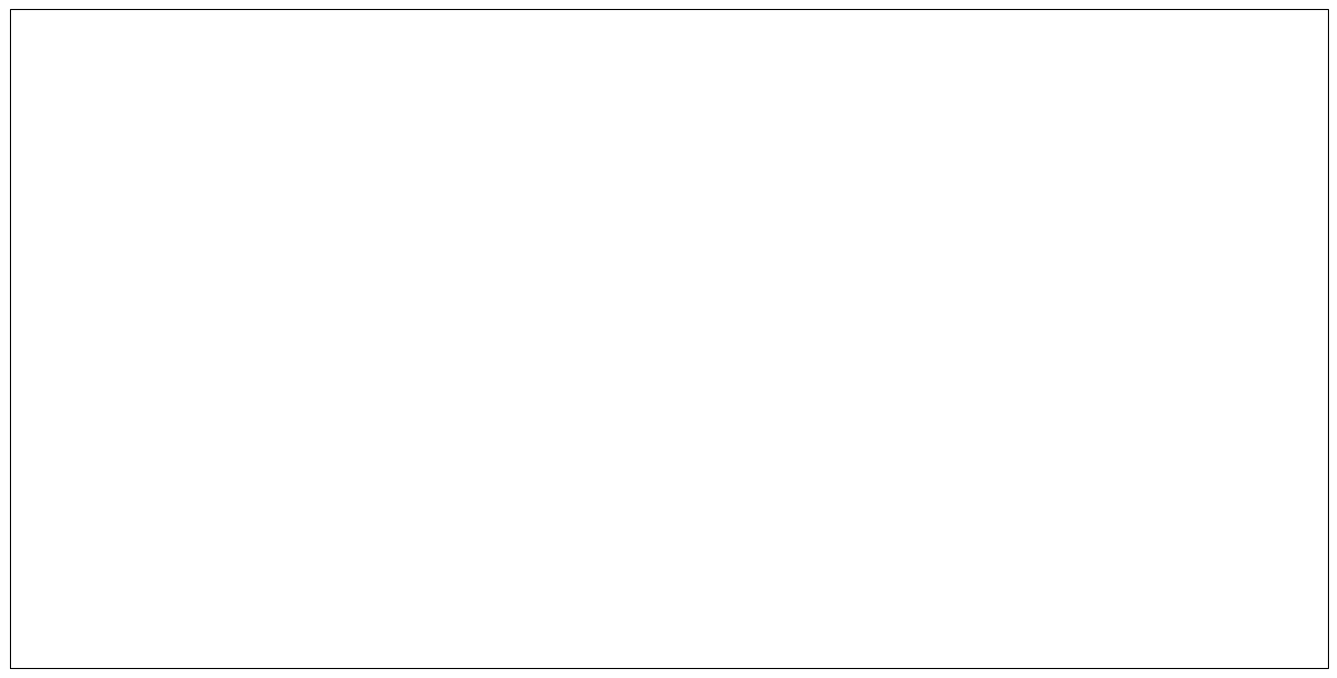

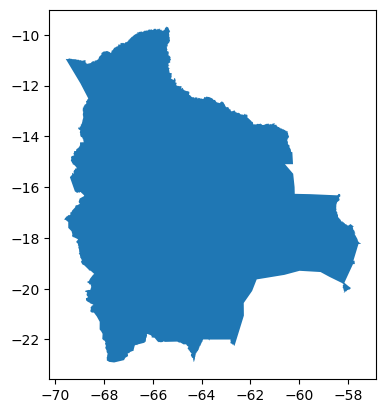

INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


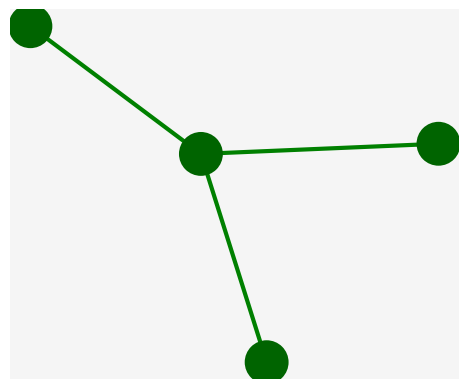

<Figure size 640x480 with 0 Axes>

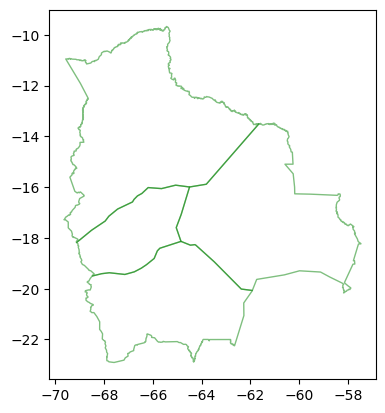

<Figure size 640x480 with 0 Axes>

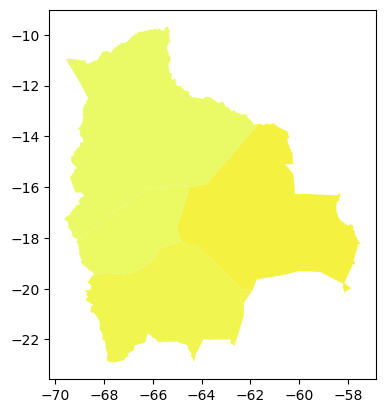

<Figure size 640x480 with 0 Axes>

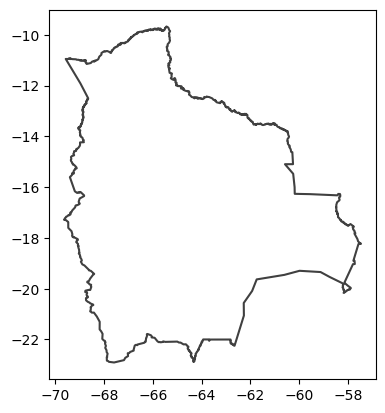

INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units


<Figure size 640x480 with 0 Axes>

In [9]:


fig, axes = plt.subplots(1,1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(17, 9)
)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.15)

country = gpd.read_file(home + "resources/shapes/country_shapes.geojson")
country.plot() # country shape
plt.show()


n = pypsa.Network(home + f"networks/elec_s_4.nc")
r = gpd.read_file(home + 
    f"resources/bus_regions/regions_onshore_elec_s_4.geojson"
).set_index("name")
factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
r["factor"] = factor

n.plot(
    color_geomap=True,
    bus_colors="red",
    bus_sizes=red_bussizes,
    line_colors="red",
    line_widths=red_linewidth,
    ax=axes,
)

n.plot(
    color_geomap=True,
    bus_colors="darkgreen",
    bus_sizes=red_bussizes,
    line_colors="green",
    line_widths=red_linewidth
)
plt.show() # four clusters

r.boundary.plot(ax=axes, color="green", linewidth=1, alpha=0.5)

r.boundary.plot(color="green", linewidth=1, alpha=0.5)
plt.show() # four zones

r.plot(ax=axes, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)

r.plot(column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
plt.show() # four zones colored

country.boundary.plot(ax=axes, color="black", alpha=0.75)
country.boundary.plot(color="black", alpha=0.75)
plt.show() # country shape

n = pypsa.Network(home + "networks/elec_s_4.nc")
r = gpd.read_file(home + "resources/bus_regions/regions_onshore_elec_s_4.geojson").set_index("name")
b = pd.read_csv(home + "resources/bus_regions/busmap_elec_s_4.csv", index_col=0).squeeze("columns")


n2 = pypsa.Network(home + f"networks/elec_s_4.nc")
r2 = gpd.read_file(
    home + f"resources/bus_regions/regions_onshore_elec_s_4.geojson"
).set_index("name")
factor = n2.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
r2["factor"] = factor

b2 = pd.read_csv(
    home + f"resources/bus_regions/busmap_elec_s_4.csv", index_col=0
).squeeze("columns")
n2.mremove("Line", n2.lines.index)

debug = 0
for nb in b.unique():
    nl = b2.loc[b[b == nb].index].unique()
    nb = n.buses.loc[nb]
    nb.name = nb.name + " ref"
    n2.madd("Bus", names=[nb.name], x=nb.x, y=nb.y)
    n2.madd(
        "Line", names=nl + f" ref line {debug}", bus0=[nb.name] * len(nl), bus1=nl
    )

    debug += 1

n.plot(
    color_geomap=True,
    bus_colors="darkgreen",
    bus_sizes=red_bussizes,
    line_colors='green',
    line_widths=red_linewidth,
    ax=axes,
)
n2.plot(bus_colors="grey", bus_sizes=1e-2, line_colors="grey", ax=axes)
r2.boundary.plot(ax=axes, color="grey", linewidth=0.25, alpha=0.5)
r2.plot(ax=axes, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
r.boundary.plot(ax=axes, color="red", linewidth=1, alpha=0.5)
country.boundary.plot(ax=axes, color="black", alpha=0.75)



# axes[0, 1].set_title(
#     "Clustering all information simultaneously", fontsize=15
# )  # , FontWeight = 'bold')
# axes[1, 1].set_title(
#     "Possibility to increase intra-nodal siting information", fontsize=15
# )  # , FontWeight = 'bold')

# Draw a horizontal line
line = plt.Line2D([0.14, 0.89], [0.52, 0.52], transform=fig.transFigure, color="black")
fig.add_artist(line)

# plt.savefig("visualise_clustering.pdf", bbox_inches="tight")
plt.show()

In [7]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

plt.rcParams['font.size'] = 18

from matplotlib.colors import LinearSegmentedColormap
colors = [teal1,teal2, teal2,teal3, teal4,beige3]
positions = [0.0, 0.05, 0.08,0.10,0.15,1]  # Ranges from 0.0 to 1.0

# Create the colormap
cmap = LinearSegmentedColormap.from_list("Xenia", list(zip(positions, colors)))
save_path = "C:/Users/xenia/OneDrive/Desktop/Uni/NTNU/Thesis/Figures/"
zones = ['Northern', 'Oriental', 'Central', 'Southern']
zone_colors=[teal3,teal1,teal4,teal2]
from matplotlib.colors import ListedColormap
# Define your custom colormap
cmap_zones = ListedColormap(zone_colors)

INFO:pypsa.io:Imported network elec_s_4.nc has buses, carriers, generators, lines, loads, storage_units
c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


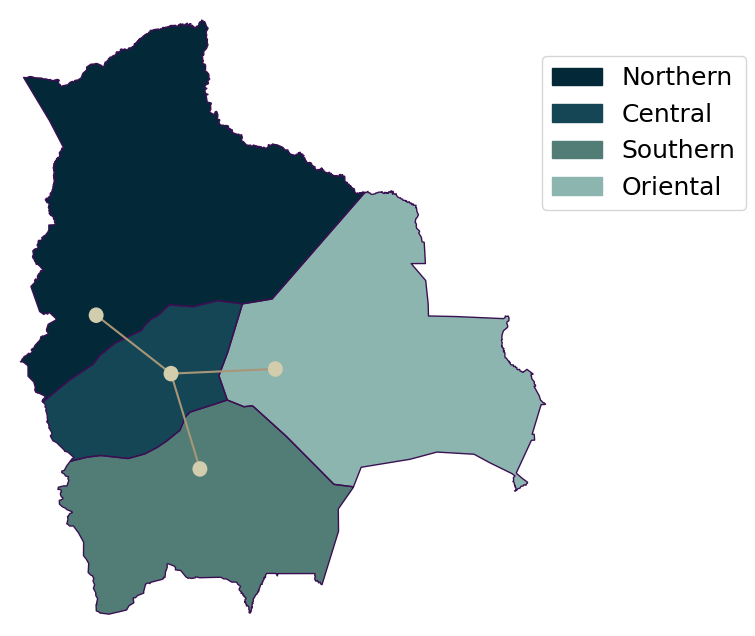

In [13]:
home = 'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/'

fig, ax1 = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()},figsize = (8,8))
 

n = pypsa.Network(home + f"networks/elec_s_4.nc")
r = gpd.read_file(home + 
    f"resources/bus_regions/regions_onshore_elec_s_4.geojson"
).set_index("name")

factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
r["factor"] = factor

n.plot(ax=ax1,
    color_geomap=False,
    bus_colors=beige3,
    bus_sizes=0.03,
    line_colors=beige2,
    line_widths=1.5
)

# 4 clusters network boundaries
ax1.set_xlim(left=min(n.buses.x)-2.0, right=max(n.buses.x)+7.2)
ax1.set_ylim(bottom=min(n.buses.y)-3.5, top=max(n.buses.y)+6.8)

# Simplified network boundaries
#ax1.set_xlim(left=min(n.buses.x)-2, right=max(n.buses.x)+6.2)
#ax1.set_ylim(bottom=min(n.buses.y)-2.0, top=max(n.buses.y)+5.3)

# Base network boundaries
#ax1.set_xlim(left=min(n.buses.x)-1.7, right=max(n.buses.x)+5.2)
#ax1.set_ylim(bottom=min(n.buses.y)-1.0, top=max(n.buses.y)+4.8)

r.boundary.plot(ax=ax1, color=purple1, linewidth=1, alpha=1) # four zones



r.plot(ax=ax1, column="factor",color=zone_colors,alpha=1, vmin=0, vmax=1) # four zones colored #  color=zone_colors

import matplotlib.patches as mpatches

northern = mpatches.Patch(color=teal1, label ='Northern')
central = mpatches.Patch(color=teal2, label ='Central')
southern = mpatches.Patch(color=teal3, label ='Southern')
oriental = mpatches.Patch(color=teal4, label ='Oriental')

handles=[northern,central,southern,oriental]
ax1.legend(handles=handles, loc="center right", bbox_to_anchor=(1.3, 0.8))
plt.savefig(save_path+'clustered_network_legend.png', dpi=300, format='png', bbox_inches='tight')


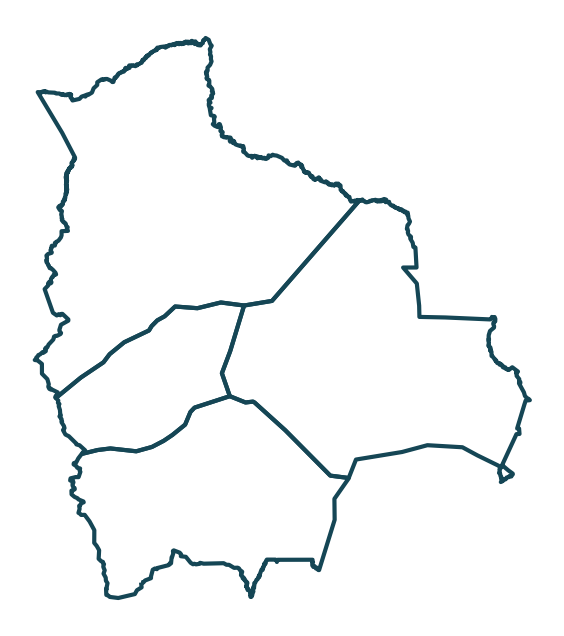

In [11]:
fig, ax1 = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()},figsize = (8,8))
r.boundary.plot(ax=ax1, color=teal2, facecolor ='none',linewidth=3, alpha=1)
ax1.set_axis_off()  # Remove axes and labels

fig.patch.set_alpha(0)  # Set the figure's background color to transparent
plt.savefig(save_path+f'zones_layout_pop.png', dpi=300, bbox_inches='tight')
